# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import NearMiss
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# Loading Dataset

In [2]:
df=pd.read_csv("C:\\New folder (3)\\churn.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.shape

(10000, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
df.describe(include='object')

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


In [6]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


# Exploratory Data Analysis

In [7]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

<Axes: xlabel='Exited', ylabel='count'>

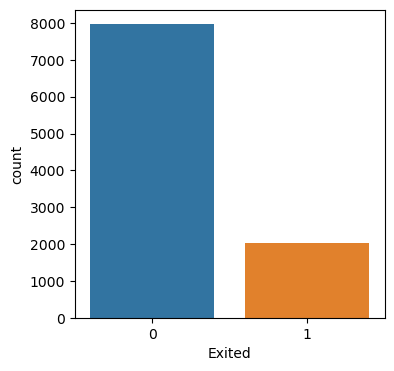

In [8]:
plt.figure(figsize=(4,4))
sns.countplot(x='Exited',data=df)

In [9]:
# Bar plot for gender

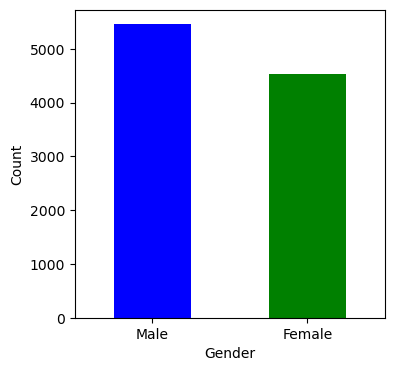

In [10]:
plt.figure(figsize=(4,4))
df['Gender'].value_counts().plot.bar(color=['b', 'g'])
plt.ylabel('Count')
plt.xlabel('Gender')
plt.xticks(rotation=0)
plt.show()

 **More males are their than females**

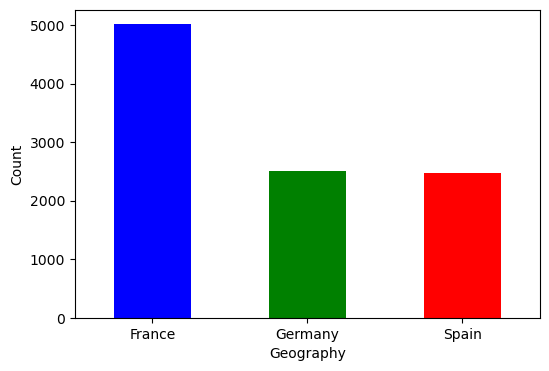

In [11]:
plt.figure(figsize=(6,4))
df['Geography'].value_counts().plot.bar(color=['b', 'g', 'r'])
plt.ylabel('Count')
plt.xlabel('Geography')
plt.xticks(rotation=0)
plt.show()

**Majority of customers are from France**

### Churn Segmentation by Gender

In [12]:
# Segment "Exited" by gender and display the frequency and percentage within each class
group_count = df.groupby('Gender')['Exited'].agg(Count='value_counts')
group_count

Count
Gender Exited       
Female 0        3404
       1        1139
Male   0        4559
       1         898

In [13]:
# dataframe for plotting count
df_group= group_count
df_group = df_group.pivot_table(values='Count', index='Gender', columns=['Exited'])
df_group

Exited,0,1
Gender,,
Female,3404,1139
Male,4559,898


In [14]:
# Calculate percentage within each class
df_group = group_count.groupby(level=[0]).apply(lambda g: round(g * 100 / g.sum(), 2))
df_group.rename(columns={'Count': 'Percentage'}, inplace=True)
df_group

Percentage
Gender Exited            
Female 0            74.93
       1            25.07
Male   0            83.54
       1            16.46

In [15]:
# Reorganize dataframe for plotting percentage
df_group = df_group.pivot_table(values='Percentage', index='Gender', columns=['Exited'])
df_group

Exited,0,1
Gender,,
Female,74.93,25.07
Male,83.54,16.46


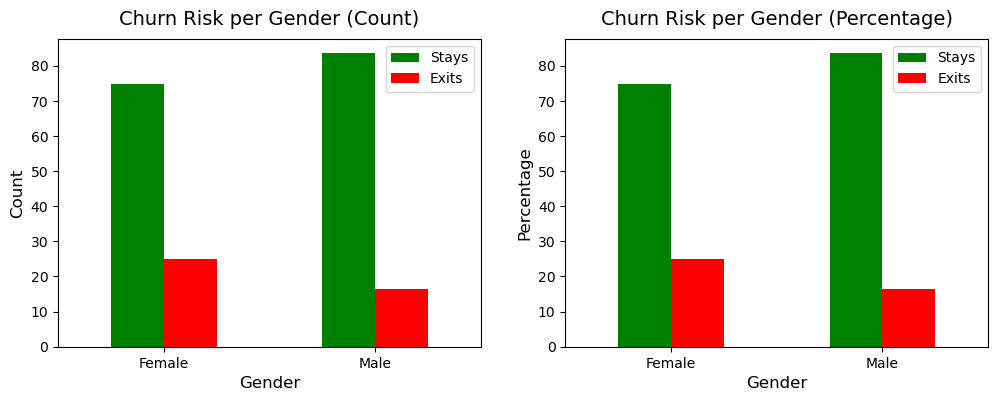

In [16]:
# Churn distribution by gender, count + percentage

labels= ['Stays', 'Exits']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

df_group.plot(kind='bar',
          color=['g', 'r'],
          rot=0, 
          ax=ax1)
ax1.legend(labels)
ax1.set_title('Churn Risk per Gender (Count)', fontsize=14, pad=10)
ax1.set_ylabel('Count',size=12)
ax1.set_xlabel('Gender', size=12)


df_group.plot(kind='bar',
          color=['g', 'r'],
          rot=0, 
          ax=ax2)
ax2.legend(labels)
ax2.set_title('Churn Risk per Gender (Percentage)', fontsize=14, pad=10)
ax2.set_ylabel('Percentage',size=12)
ax2.set_xlabel('Gender', size=12)

plt.show()

**The count and percentage for Exiting is more among females than males**

In [17]:
df.head(1)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,101348.88,1


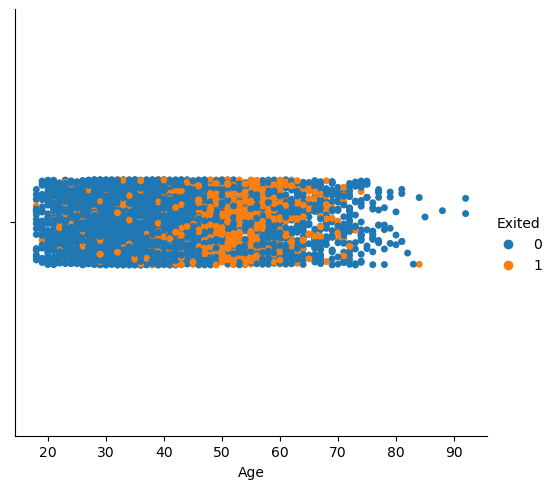

In [18]:
sns.catplot(x='Age',hue='Exited',data=df)

**Older people are more likely to leave the bank**

([<matplotlib.patches.Wedge at 0x1f694e7b700>,
 [Text(0.3412091840810337, 1.045741981895513, 'Germany'),
  Text(-0.8962571161403855, -0.6377485254923917, 'France'),
  Text(0.8843014545578098, -0.6542254485014644, 'Spain')],
 [Text(0.18611410040783652, 0.5704047173975525, '39.96'),
  Text(-0.4888675178947557, -0.3478628320867591, '39.76'),
  Text(0.4823462479406235, -0.3568502446371623, '20.27')])

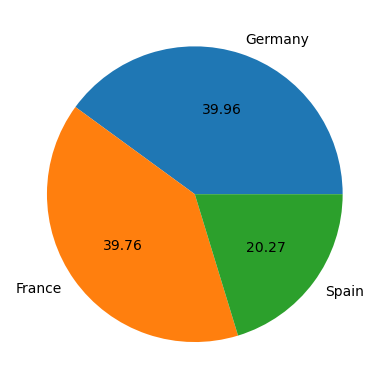

In [19]:
churn_data=df[df['Exited']==1]
plt.pie(churn_data['Geography'].value_counts(),labels=churn_data['Geography'].value_counts().index,autopct='%.2f')

**Germany has high number of Exited population followed by france and Spain**

**So the authorities should look into the rules and compare with other countries to find out where they are lagging behind so that they can improve**

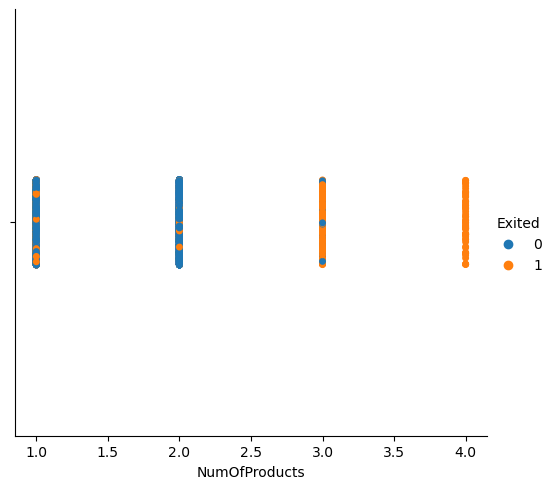

In [20]:
sns.catplot(x='NumOfProducts',hue='Exited',data=df)

**People who have more number of products from bank are more likely to leave**

**This may be due to low quality of products provided by banks.So,bank should maintain the quality of products they are providing to their customers**

<Axes: xlabel='HasCrCard', ylabel='IsActiveMember'>

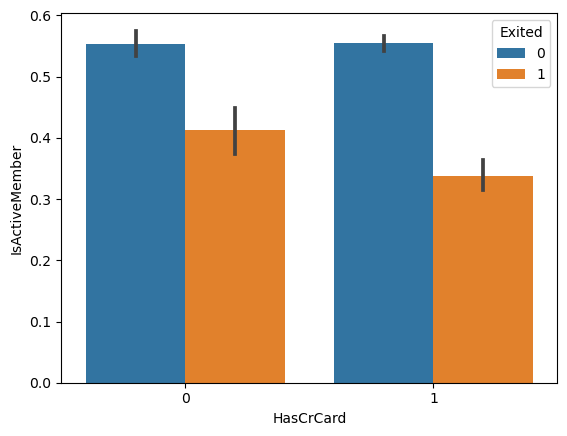

In [21]:
sns.barplot(x='HasCrCard',y='IsActiveMember',hue='Exited',data=df)

**People not having Credit Card are more likely to leave the bank**

**Credit Card act as bridge between Bank and customers maintaining relationships between them**

In [22]:
df.head(1)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,101348.88,1


<Axes: xlabel='IsActiveMember', ylabel='Density'>

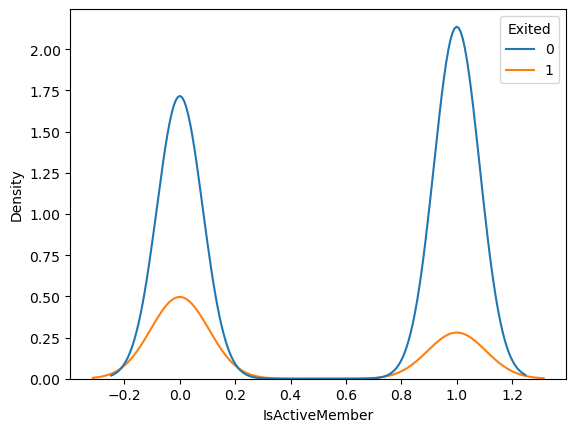

In [23]:
sns.kdeplot(x='IsActiveMember',hue='Exited',data=df)

**People who are not active member or less actively participating in bank activity(transactions etc.) are more likely to churn**

**We should keep a note of such people and communicate with them so that they can be provided with better solutions**

<Axes: xlabel='CreditScore', ylabel='Density'>

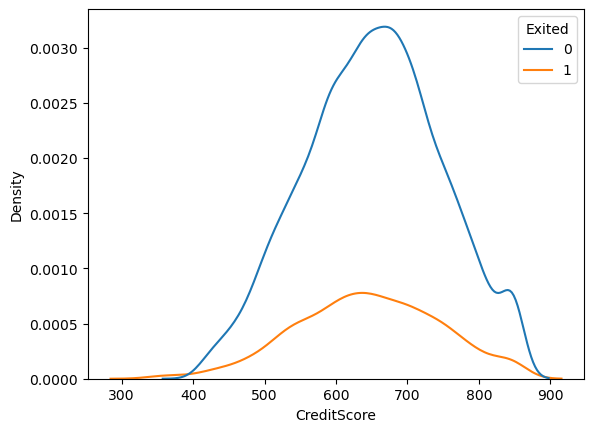

In [24]:
sns.kdeplot(x='CreditScore',hue='Exited',data=df)

**People having less credit score are more likely to churn**

**Low credit score occur when customer is not regular with loan repayments,in such a case bank should consult with such people what is the issue such people are facing and try to reduce their monthly interests so that credit score could be improved and these prople are less likely to churn**

In [25]:
df.head(1)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,101348.88,1


<Axes: xlabel='Tenure', ylabel='Density'>

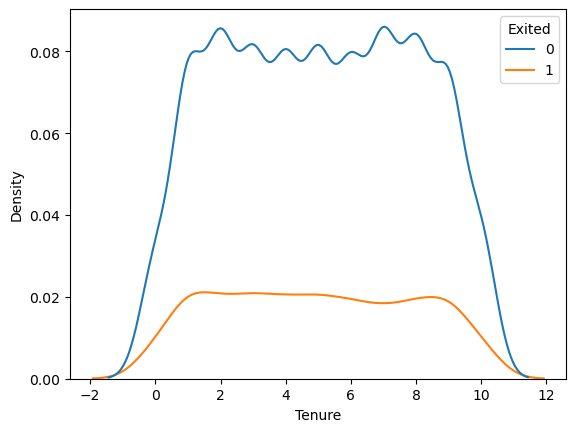

In [26]:
sns.kdeplot(x='Tenure',hue='Exited',data=df)

**Less duration of tenure shows more Exited rate**

<Axes: xlabel='Tenure', ylabel='count'>

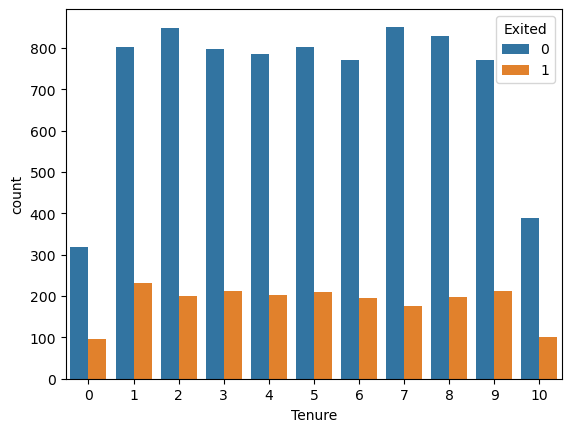

In [27]:
sns.countplot(x='Tenure',hue='Exited',data=df)

**People with less tenure with bank are exiting from banks**

**So bank should focus on to increase the tenure of people coming their**

In [28]:
# drop columns
df.drop(['RowNumber', 'Surname'], axis=1, inplace=True)
df.columns

Index(['CustomerId', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

In [29]:
df.head(1)

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,France,Female,42,2,0.0,1,1,1,101348.88,1


In [30]:
df.drop(['CustomerId'],axis=1,inplace=True)

In [31]:
df.head(1)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.0,1,1,1,101348.88,1


In [32]:
X=df.iloc[:,:-1]
y=df['Exited']

# Splitting data into train and test

In [33]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.2,random_state=0)

In [34]:
(X_train.shape),(X_test.shape),(y_train.shape)

((8000, 10), (2000, 10), (8000,))

# Feature Engineering

## Missing Values

In [35]:
X_train.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

# Categorical Columns

In [36]:
# identify categorical columns in the DataFrame
category = [i for i in X_train.columns if X_train[i].dtype == 'object']

# iterate over each categorical column
for col in category:
    # print the value counts for the current column
    print(X_train[col].value_counts())
    print()

France     4008
Germany    2004
Spain      1988
Name: Geography, dtype: int64

Male      4368
Female    3632
Name: Gender, dtype: int64



In [37]:
# show category columns
df[category].columns

Index(['Geography', 'Gender'], dtype='object')

# One hot Encoding

In [38]:
X_train=pd.get_dummies(data=X_train,columns=['Geography','Gender'],drop_first=True)

In [39]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
493,531,47,6,0.00,1,0,0,194998.34,0,0,0
6839,724,36,6,94615.11,2,1,1,10627.21,1,0,1
170,484,29,4,130114.39,1,1,0,164017.89,0,0,0
4958,655,37,6,109093.41,2,1,0,1775.52,0,0,1
4271,465,33,5,0.00,2,0,1,78698.09,0,0,1


In [40]:
X_train=X_train.rename(columns={'Gender_Male':'gender','Geography_Germany':'germany','Geography_Spain':'spain'})

In [41]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,germany,spain,gender
493,531,47,6,0.00,1,0,0,194998.34,0,0,0
6839,724,36,6,94615.11,2,1,1,10627.21,1,0,1
170,484,29,4,130114.39,1,1,0,164017.89,0,0,0
4958,655,37,6,109093.41,2,1,0,1775.52,0,0,1
4271,465,33,5,0.00,2,0,1,78698.09,0,0,1


# Feature Scaling

In [42]:
from sklearn.preprocessing import MinMaxScaler as MMS

In [43]:
scaler=MMS()

In [44]:
X_train = scaler.fit_transform(X_train)

In [45]:
X_train

array([[0.362     , 0.39189189, 0.6       , ..., 0.        , 0.        ,
        0.        ],
       [0.748     , 0.24324324, 0.6       , ..., 1.        , 0.        ,
        1.        ],
       [0.268     , 0.14864865, 0.4       , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.502     , 0.40540541, 0.9       , ..., 1.        , 0.        ,
        1.        ],
       [0.744     , 0.22972973, 0.2       , ..., 0.        , 0.        ,
        0.        ],
       [0.786     , 0.09459459, 0.6       , ..., 0.        , 1.        ,
        1.        ]])

# Feature Engineering for test dataset

## Missing Values

In [46]:
X_test.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

## Categorical Columns

In [47]:
#identify categorical columns in the DataFrame
category = [i for i in X_test.columns if X_test[i].dtype == 'object']

# iterate over each categorical column
for col in category:
    # print the value counts for the current column
    print(X_test[col].value_counts())
    print()

France     1006
Germany     505
Spain       489
Name: Geography, dtype: int64

Male      1089
Female     911
Name: Gender, dtype: int64



# One hot Encoding

In [48]:
X_test=pd.get_dummies(data=X_test,columns=['Geography','Gender'],drop_first=True)

In [49]:
X_test

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
1344,460,40,6,119507.58,2,1,0,91560.63,1,0,0
8167,713,24,7,147687.24,1,1,1,121592.50,1,0,0
4747,663,64,6,0.00,2,0,1,15876.52,0,1,1
5004,502,57,3,101465.31,1,1,0,43568.31,1,0,0
3124,760,39,6,178585.46,1,1,0,67131.30,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
9107,655,38,9,0.00,1,0,1,90490.33,0,1,1
8249,586,38,6,0.00,2,1,1,37935.83,0,0,0
8337,534,41,9,0.00,2,1,0,13871.34,0,0,1
6279,757,55,9,117294.12,4,1,0,94187.47,0,1,0


In [50]:
X_test=X_test.rename(columns={'Gender_Male':'gender','Geography_Germany':'germany','Geography_Spain':'spain'})

In [51]:
X_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,germany,spain,gender
1344,460,40,6,119507.58,2,1,0,91560.63,1,0,0
8167,713,24,7,147687.24,1,1,1,121592.50,1,0,0
4747,663,64,6,0.00,2,0,1,15876.52,0,1,1
5004,502,57,3,101465.31,1,1,0,43568.31,1,0,0
3124,760,39,6,178585.46,1,1,0,67131.30,0,0,1


# Feature Scaling

In [52]:
X_test = scaler.fit_transform(X_test)
X_test

array([[0.22      , 0.31428571, 0.6       , ..., 1.        , 0.        ,
        0.        ],
       [0.726     , 0.08571429, 0.7       , ..., 1.        , 0.        ,
        0.        ],
       [0.626     , 0.65714286, 0.6       , ..., 0.        , 1.        ,
        1.        ],
       ...,
       [0.368     , 0.32857143, 0.9       , ..., 0.        , 0.        ,
        1.        ],
       [0.814     , 0.52857143, 0.9       , ..., 0.        , 1.        ,
        0.        ],
       [0.79      , 0.18571429, 0.3       , ..., 0.        , 1.        ,
        0.        ]])

## Correlation

In [53]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

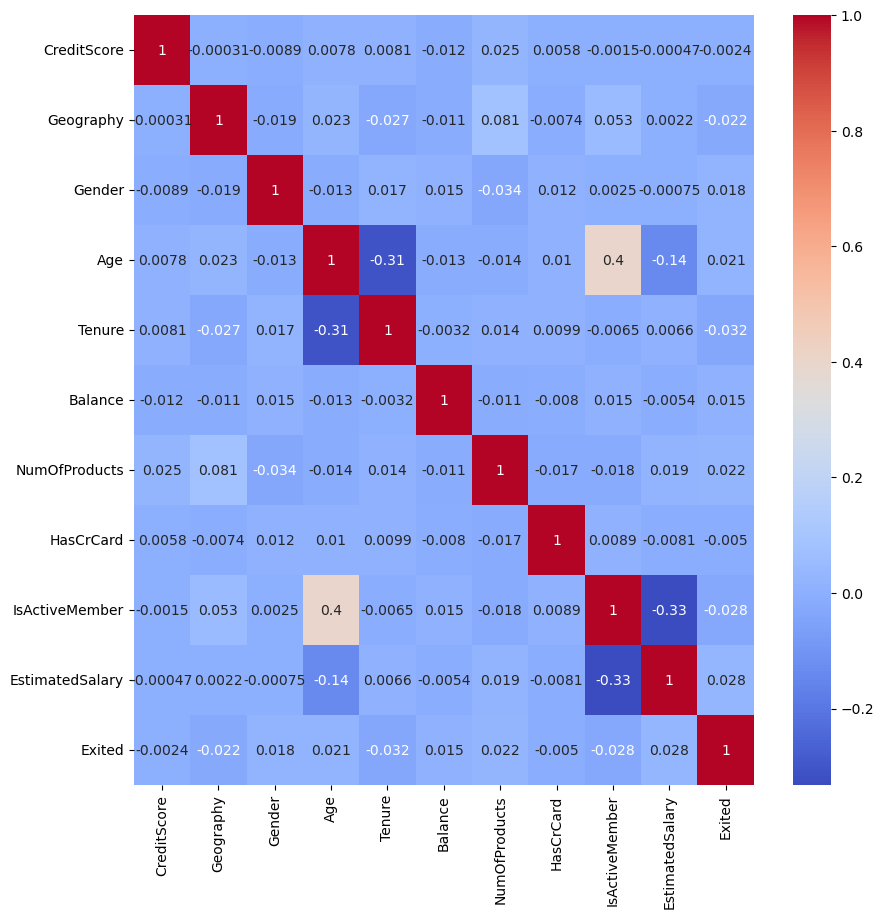

In [54]:
X_train_df = pd.DataFrame(X_train, columns=['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'])  # Replace 'feature1', 'feature2', etc. with your actual feature names

# Calculate the correlation matrix
cor = X_train_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cor, annot=True, cmap='coolwarm')
plt.show()

**The graph above shows that there are not many features that are strongly correlated linearly with the target. This means that most of the correlations contained in the dataset are non-linear. Based on this, the appropriate model to use is a model that has good performance on datasets that have many non-linear correlations such as Decision Trees, Gradient Boosting and Support Vector Machines (SVM)**.

# Solving Imbalance of Dataset

In [55]:
from collections import Counter
from imblearn.over_sampling import ADASYN
X_resampled, y_resampled = ADASYN().fit_resample(X_train,y_train)
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_resampled).items()))

[(0, 6370), (1, 1630)]
[(0, 6370), (1, 6820)]


# Model Building

In [56]:

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RFC
# splitting data and model evaluation
from sklearn.metrics import recall_score, f1_score, roc_auc_score, make_scorer,accuracy_score ,classification_report, confusion_matrix
# cross-validation and hyperparameter tuning
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

# Naive Bayes

In [57]:
# initialize the Naive Bayes classifier and fit it to the resampled training data

NB_classifier = GaussianNB()
NB_classifier.fit(X_resampled, y_resampled)

# make predictions on the test data
y_pred = NB_classifier.predict(X_test)

# calculate metric evaluation and confusion matrix
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# print the result
print("="*55)
print("Recall       :", recall)
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

print("="*55)
print("Classification Report:\n\n", classification_report(y_test, y_pred))
print("="*55)

print("Confusion Matrix:\n\n", cm)
print("="*55)

Recall       : 0.7714987714987716
ROC-AUC Score: 0.7134330015685948
Classification Report:

               precision    recall  f1-score   support

           0       0.92      0.66      0.76      1593
           1       0.36      0.77      0.49       407

    accuracy                           0.68      2000
   macro avg       0.64      0.71      0.63      2000
weighted avg       0.81      0.68      0.71      2000

Confusion Matrix:

 [[1044  549]
 [  93  314]]


# Cross Validation

In [58]:
# initialize a K-Fold cross-validation object with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# compute the cross-validation recall scores and ROC-AUC scores for the untuned NB classifier
nb_cv_recall_scores = cross_val_score(NB_classifier, X_resampled, y_resampled, 
                                            cv=kf, n_jobs=-1, scoring='recall').mean()
nb_cv_roc_auc_scores = cross_val_score(NB_classifier, X_resampled, y_resampled, 
                                            cv=kf, n_jobs=-1, scoring='roc_auc').mean()

# print the cross-validation results
print(f"The cross-validation recall and ROC-AUC score for untuned after a 10 fold cross validation:")
print("Recall   :", nb_cv_recall_scores)
print("ROC-AUC  :", nb_cv_roc_auc_scores)

The cross-validation recall and ROC-AUC score for untuned after a 10 fold cross validation:
Recall   : 0.7194836006722194
ROC-AUC  : 0.7859874446664804


In [59]:
print(NB_classifier.get_params())

{'priors': None, 'var_smoothing': 1e-09}


# Hyperparameter Tuning

In [60]:
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}

# initialize GridSearchCV objects for recall and ROC-AUC score
grid_recall = GridSearchCV(NB_classifier, param_grid, cv=kf, n_jobs=-1, scoring='recall')
grid_roc_auc = GridSearchCV(NB_classifier, param_grid, cv=kf, n_jobs=-1, scoring='roc_auc')

# perform grid search for recall and ROC-AUC score
grid_recall.fit(X_resampled, y_resampled)
grid_roc_auc.fit(X_resampled, y_resampled)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06]},
             scoring='roc_auc')

In [61]:
best_hyperparams_recall = grid_recall.best_params_
best_hyperparams_roc_auc = grid_roc_auc.best_params_

print("Best hyperparameters for recall and ROC-AUC:")
print(best_hyperparams_recall)

print(best_hyperparams_roc_auc)

nb_cv_recall_scores = grid_recall.best_score_
nb_cv_roc_auc_scores = grid_roc_auc.best_score_

print(f"\nThe cross-validation recall and ROC-AUC score for tuned after a 10 fold cross validation:")
print("Recall   :", nb_cv_recall_scores)
print("ROC-AUC  :", nb_cv_roc_auc_scores)

best_nb_model = grid_recall.best_estimator_

Best hyperparameters for recall and ROC-AUC:
{'var_smoothing': 1e-09}
{'var_smoothing': 1e-09}

The cross-validation recall and ROC-AUC score for tuned after a 10 fold cross validation:
Recall   : 0.7194836006722194
ROC-AUC  : 0.7859874446664804


In [62]:
best_nb_fit_for_train_data_recall = cross_val_score(best_nb_model, X_resampled, y_resampled,
                                             cv=kf, n_jobs=-1, scoring='recall').mean()

best_nb_fit_for_train_data_rocauc = cross_val_score(best_nb_model, X_resampled, y_resampled,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()

print("Train Data")
print("Recall   :", best_nb_fit_for_train_data_recall)
print("ROC-AUC  :", best_nb_fit_for_train_data_rocauc)

best_nb_fit_for_test_data_recall = cross_val_score(best_nb_model, X_test, y_test, 
                                            cv=kf, n_jobs=-1).mean()
best_nb_fit_for_test_data_rocauc = cross_val_score(best_nb_model, X_test, y_test,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()

print("Test Data")
print("Recall   :", best_nb_fit_for_test_data_recall)
print("ROC-AUC  :", best_nb_fit_for_test_data_rocauc)

Train Data
Recall   : 0.7194836006722194
ROC-AUC  : 0.7859874446664804
Test Data
Recall   : 0.8295
ROC-AUC  : 0.7820165613284501


# Decision Tree

In [63]:
# initialize the Decision Tree classifier and fit it to the resampled training data
DT = DecisionTreeClassifier()
DT.fit(X_resampled, y_resampled)

# make predictions on the test data
y_pred = DT.predict(X_test)

# calculate metric evaluation and confusion matrix
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# print the result
print("="*55)
print("Recall       :", recall)
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

print("="*55)
print("Classification Report:\n\n", classification_report(y_test, y_pred))
print("="*55)

print("Confusion Matrix:\n\n", cm)
print("="*55)

Recall       : 0.7616707616707616
ROC-AUC Score: 0.6994166739929452
Classification Report:

               precision    recall  f1-score   support

           0       0.91      0.64      0.75      1593
           1       0.35      0.76      0.48       407

    accuracy                           0.66      2000
   macro avg       0.63      0.70      0.61      2000
weighted avg       0.80      0.66      0.70      2000

Confusion Matrix:

 [[1015  578]
 [  97  310]]


# Cross Validation

In [64]:
# compute the cross-validation recall scores and ROC-AUC scores for the untuned DT classifier
dt_before_tuned_cv_recall_scores = cross_val_score(DT, X_resampled, y_resampled, 
                                            cv=kf, n_jobs=-1, scoring='recall').mean()
dt_before_tuned_cv_rocauc_scores = cross_val_score(DT, X_resampled, y_resampled, 
                                            cv=kf, n_jobs=-1, scoring='roc_auc').mean()

# print the cross-validation results
print(f"The cross-validation recall and ROC-AUC score for untuned  after a 10 fold cross validation:")
print("Recall   :", dt_before_tuned_cv_recall_scores)
print("ROC-AUC  :", dt_before_tuned_cv_rocauc_scores)

The cross-validation recall and ROC-AUC score for untuned  after a 10 fold cross validation:
Recall   : 0.8557798998344541
ROC-AUC  : 0.8468049470565904


In [65]:
print(DT.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


# Hyperparameter Tuning

In [66]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# initialize GridSearchCV objects for recall and ROC-AUC score
grid_dt_recall = GridSearchCV(DT, param_grid, cv=kf, n_jobs=-1, scoring='recall')
grid_dt_rocauc = GridSearchCV(DT, param_grid, cv=kf, n_jobs=-1, scoring='roc_auc')

# perform grid search for recall and ROC-AUC score
grid_dt_recall.fit(X_resampled, y_resampled)
grid_dt_rocauc.fit(X_resampled, y_resampled)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='roc_auc')

In [67]:
best_hyperparams_recall = grid_dt_recall.best_params_
best_hyperparams_rocauc = grid_dt_rocauc.best_params_

print("Best hyperparameters for recall and ROC-AUC:")
print("Recall :\n", best_hyperparams_recall)
print("ROC-AUC  :\n", best_hyperparams_rocauc)

dt_after_tuned_cv_recall_scores = grid_dt_recall.best_score_
dt_after_tuned_cv_rocauc_scores = grid_dt_rocauc.best_score_

print(f"\nThe cross-validation recall and ROC-AUC score for tuned  after a 10 fold cross validation:")
print("Recall :", dt_after_tuned_cv_recall_scores)
print("ROC-AUC  :", dt_after_tuned_cv_rocauc_scores)

best_dt_model = grid_dt_recall.best_estimator_

Best hyperparameters for recall and ROC-AUC:
Recall :
 {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
ROC-AUC  :
 {'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}

The cross-validation recall and ROC-AUC score for tuned  after a 10 fold cross validation:
Recall : 0.8666995427080959
ROC-AUC  : 0.9123173898255776


In [68]:
best_dt_fit_for_train_data_recall = cross_val_score(best_dt_model, X_resampled, y_resampled,
                                             cv=kf, n_jobs=-1, scoring='recall').mean()

best_dt_fit_for_train_data_rocauc = cross_val_score(best_dt_model, X_resampled, y_resampled,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()

print("Train Data")
print("Recall   :", best_dt_fit_for_train_data_recall)
print("ROC-AUC  :", best_dt_fit_for_train_data_rocauc)

best_dt_fit_for_test_data_recall = cross_val_score(best_dt_model, X_test, y_test, 
                                            cv=kf, n_jobs=-1).mean()
best_dt_fit_for_test_data_rocauc = cross_val_score(best_dt_model, X_test, y_test,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()
print("Test Data")
print("Recall   :", best_dt_fit_for_test_data_recall)
print("ROC-AUC  :", best_dt_fit_for_test_data_rocauc)

Train Data
Recall   : 0.8656839176880643
ROC-AUC  : 0.8534038160573507
Test Data
Recall   : 0.789
ROC-AUC  : 0.6728418478546676


# Random Forest Classifier

In [69]:
# initialize the Random Forest classifier and fit it to the resampled training data
Clf=RFC()
Clf.fit(X_resampled, y_resampled)

# make predictions on the test data
y_pred = Clf.predict(X_test)

# calculate metric evaluation and confusion matrix
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# print the result
print("="*55)
print("Recall       :", recall)
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

print("="*55)
print("Classification Report:\n\n", classification_report(y_test, y_pred))
print("="*55)

print("Confusion Matrix:\n\n", cm)
print("="*55)

Recall       : 0.6633906633906634
ROC-AUC Score: 0.7431830906407179
Classification Report:

               precision    recall  f1-score   support

           0       0.91      0.82      0.86      1593
           1       0.49      0.66      0.56       407

    accuracy                           0.79      2000
   macro avg       0.70      0.74      0.71      2000
weighted avg       0.82      0.79      0.80      2000

Confusion Matrix:

 [[1311  282]
 [ 137  270]]


# Cross Validation

In [70]:
# compute the cross-validation recall scores and ROC-AUC scores for the untuned classifier
rf_before_tuned_cv_recall_scores = cross_val_score(Clf, X_resampled, y_resampled, 
                                            cv=kf, n_jobs=-1, scoring='recall').mean()
rf_before_tuned_cv_rocauc_scores = cross_val_score(Clf, X_resampled, y_resampled, 
                                            cv=kf, n_jobs=-1, scoring='roc_auc').mean()

# print the cross-validation results
print(f"The cross-validation recall and ROC-AUC score for untuned after a 10 fold cross validation:")
print("Recall   :", rf_before_tuned_cv_recall_scores)
print("ROC-AUC  :", rf_before_tuned_cv_rocauc_scores)

The cross-validation recall and ROC-AUC score for untuned after a 10 fold cross validation:
Recall   : 0.9208739123338706
ROC-AUC  : 0.9654122348135813


In [71]:
print(Clf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


# Hyperparameter Tuning

In [72]:
parameter={'n_estimators' : [int(x) for x in np.linspace(start=100,stop=400,num=30)],

# Number of features to consider at every split
'max_features' :[0.2,0.6,1.0],

# Maximum number of levels in tree
'max_depth':[2,8,None],

# Number of samples
'max_samples' : [0.5,0.75,1.0],

# Bootstrap samples
'bootstrap' : [True,False],

# Minimum number of samples required to split a node
'min_samples_split' : [2, 5],

# Minimum number of samples required at each leaf node
'min_samples_leaf' : [1, 2]}

# initialize RandomizedSearchCV objects for recall and ROC-AUC score
random_rf_recall = RandomizedSearchCV(Clf, parameter, cv=kf, n_jobs=-1, scoring='recall')
random_rf_rocauc = RandomizedSearchCV(Clf, parameter, cv=kf, n_jobs=-1, scoring='roc_auc')

# perform  randomized search for recall and ROC-AUC score
random_rf_recall.fit(X_resampled, y_resampled)
random_rf_rocauc.fit(X_resampled, y_resampled)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 8, None],
                                        'max_features': [0.2, 0.6, 1.0],
                                        'max_samples': [0.5, 0.75, 1.0],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   scoring='roc_auc')

In [73]:
best_hyperparams_recall = random_rf_recall.best_params_
best_hyperparams_rocauc = random_rf_rocauc.best_params_

print("Best hyperparameters for recall and ROC-AUC:")
print("Recall :\n", best_hyperparams_recall)
print("ROC-AUC  :\n", best_hyperparams_rocauc)

rf_after_tuned_cv_recall_scores = random_rf_recall.best_score_
rf_after_tuned_cv_rocauc_scores = random_rf_rocauc.best_score_

print(f"\nThe cross-validation recall and ROC-AUC score for tuned after a 10 fold cross validation:")
print("Recall :", rf_after_tuned_cv_recall_scores)
print("ROC-AUC  :", rf_after_tuned_cv_rocauc_scores)

best_rf_model = random_rf_recall.best_estimator_

Best hyperparameters for recall and ROC-AUC:
Recall :
 {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
ROC-AUC  :
 {'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}

The cross-validation recall and ROC-AUC score for tuned after a 10 fold cross validation:
Recall : 0.8666995427080959
ROC-AUC  : 0.9123173898255776


In [95]:
best_rf_fit_for_train_data_recall = cross_val_score(best_rf_model, X_resampled, y_resampled,
                                             cv=kf, n_jobs=-1, scoring='recall').mean()

best_rf_fit_for_train_data_rocauc = cross_val_score(best_rf_model, X_resampled, y_resampled,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()

print("Train Data")
print("Recall   :", best_rf_fit_for_train_data_recall)
print("ROC-AUC  :", best_rf_fit_for_train_data_rocauc)

best_rf_fit_for_test_data_recall = cross_val_score(best_rf_model, X_test, y_test, 
                                            cv=kf, n_jobs=-1).mean()
best_rf_fit_for_test_data_rocauc = cross_val_score(best_rf_model, X_test, y_test,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()
print("Test Data")
print("Recall   :", best_rf_fit_for_test_data_recall)
print("ROC-AUC  :", best_rf_fit_for_test_data_rocauc)

Train Data
Recall   : 0.713003378784929
ROC-AUC  : 0.7569997749924292
Test Data
Recall   : 0.8109999999999999
ROC-AUC  : 0.7560050458089499


# Xgboost Classifier

In [75]:
# initialize the XGB classifier and fit it to the resampled training data
XGB=XGBClassifier()
XGB.fit(X_resampled, y_resampled)

# make predictions on the test data
y_pred = XGB.predict(X_test)

# calculate metric evaluation and confusion matrix
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# print the result
print("="*55)
print("Recall       :", recall)
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

print("="*55)
print("Classification Report:\n\n", classification_report(y_test, y_pred))
print("="*55)

print("Confusion Matrix:\n\n", cm)
print("="*55)

Recall       : 0.800982800982801
ROC-AUC Score: 0.7281750163106094
Classification Report:

               precision    recall  f1-score   support

           0       0.93      0.66      0.77      1593
           1       0.37      0.80      0.51       407

    accuracy                           0.69      2000
   macro avg       0.65      0.73      0.64      2000
weighted avg       0.81      0.69      0.72      2000

Confusion Matrix:

 [[1044  549]
 [  81  326]]


# Cross Validation

In [76]:
# compute the cross-validation recall scores and ROC-AUC scores for the untuned DT classifier
xgb_before_tuned_cv_recall_scores = cross_val_score(XGB, X_resampled, y_resampled, 
                                            cv=kf, n_jobs=-1, scoring='recall').mean()
xgb_before_tuned_cv_rocauc_scores = cross_val_score(XGB, X_resampled, y_resampled, 
                                            cv=kf, n_jobs=-1, scoring='roc_auc').mean()

# print the cross-validation results
print(f"The cross-validation recall and ROC-AUC score for untuned after a 10 fold cross validation:")
print("Recall   :", xgb_before_tuned_cv_recall_scores)
print("ROC-AUC  :", xgb_before_tuned_cv_rocauc_scores)

The cross-validation recall and ROC-AUC score for untuned after a 10 fold cross validation:
Recall   : 0.8877312147540964
ROC-AUC  : 0.9656940013488576


In [77]:
print(XGB.get_params())

{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


# Hyperparameter Tuning

In [78]:
params={'eta':[0.004,0.006,0.009,0.01,0.03,0.05,0.07,0.09,0.1,0.3],
           'gamma':[5,10,15,20,25,30,40,50,60,70,80,90,100],
           'max_depth':[int(x) for x in np.linspace(5,30,num=6)],
           'min_child_weight':[3,4,5,6,7],
           'subsample':[0.6,0.7,0.8]}

# initialize RandomizedSearchCV objects for recall and ROC-AUC score
random_xgb_recall = RandomizedSearchCV(XGB, params, cv=kf, n_jobs=-1, scoring='recall')
random_xgb_rocauc = RandomizedSearchCV(XGB, params, cv=kf, n_jobs=-1, scoring='roc_auc')

# perform Randomized search for recall and ROC-AUC score
random_xgb_recall.fit(X_resampled, y_resampled)
random_xgb_rocauc.fit(X_resampled, y_resampled)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=N...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'eta': [0.004, 0.006, 0.009, 0.01, 0.03,
                                                0.05, 0.07, 0.09, 0.1, 0.3],
                                        'gamma': [5, 10, 15, 20, 25, 30, 40, 50,
                                                  60, 70, 80, 90, 100],
                                        'max_depth': [5, 10, 15, 20, 25, 30],
                                        'min_child_weight': [3, 4, 5, 6, 7],
                                        'subsample': [0.6, 0.7, 0.8]},
                   scoring='roc_auc')

In [79]:
best_hyperparams_recall = random_xgb_recall.best_params_
best_hyperparams_rocauc = random_xgb_rocauc.best_params_

print("Best hyperparameters for recall and ROC-AUC:")
print("Recall :\n", best_hyperparams_recall)
print("ROC-AUC  :\n", best_hyperparams_rocauc)

xgb_after_tuned_cv_recall_scores = random_xgb_recall.best_score_
xgb_after_tuned_cv_rocauc_scores = random_xgb_rocauc.best_score_

print(f"\nThe cross-validation recall and ROC-AUC score for tuned after a 10 fold cross validation:")
print("Recall :", xgb_after_tuned_cv_recall_scores)
print("ROC-AUC  :", xgb_after_tuned_cv_rocauc_scores)

best_dt_model = random_xgb_recall.best_estimator_

Best hyperparameters for recall and ROC-AUC:
Recall :
 {'subsample': 0.8, 'min_child_weight': 4, 'max_depth': 10, 'gamma': 10, 'eta': 0.09}
ROC-AUC  :
 {'subsample': 0.7, 'min_child_weight': 7, 'max_depth': 30, 'gamma': 10, 'eta': 0.3}

The cross-validation recall and ROC-AUC score for tuned after a 10 fold cross validation:
Recall : 0.8819837855115307
ROC-AUC  : 0.9629825600543096


In [94]:
best_xgb_fit_for_train_data_recall = cross_val_score(best_xgb_model, X_resampled, y_resampled,
                                             cv=kf, n_jobs=-1, scoring='recall').mean()

best_xgb_fit_for_train_data_rocauc = cross_val_score(best_xgb_model, X_resampled, y_resampled,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()

print("Train Data")
print("Recall   :", best_xgb_fit_for_train_data_recall)
print("ROC-AUC  :", best_xgb_fit_for_train_data_rocauc)

best_xgb_fit_for_test_data_recall = cross_val_score(best_xgb_model, X_test, y_test, 
                                            cv=kf, n_jobs=-1).mean()
best_xgb_fit_for_test_data_rocauc = cross_val_score(best_xgb_model, X_test, y_test,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()
print("Test Data")
print("Recall   :", best_xgb_fit_for_test_data_recall)
print("ROC-AUC  :", best_xgb_fit_for_test_data_rocauc)

Train Data
Recall   : 0.713003378784929
ROC-AUC  : 0.7569997749924292
Test Data
Recall   : 0.8109999999999999
ROC-AUC  : 0.7560050458089499


# Logistic Regression

In [82]:
# initialize the Logistic Regression and fit it to the resampled training data

lgc=LogisticRegression()
lgc.fit(X_resampled, y_resampled)
# make predictions on the test data
y_pred = lgc.predict(X_test)

# calculate metric evaluation and confusion matrix
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# print the result
print("="*55)
print("Recall       :", recall)
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

print("="*55)
print("Classification Report:\n\n", classification_report(y_test, y_pred))
print("="*55)

print("Confusion Matrix:\n\n", cm)
print("="*55)

Recall       : 0.7911547911547911
ROC-AUC Score: 0.7044286196828571
Classification Report:

               precision    recall  f1-score   support

           0       0.92      0.62      0.74      1593
           1       0.35      0.79      0.48       407

    accuracy                           0.65      2000
   macro avg       0.63      0.70      0.61      2000
weighted avg       0.80      0.65      0.69      2000

Confusion Matrix:

 [[984 609]
 [ 85 322]]


# Cross Validation

In [83]:
# compute the cross-validation recall scores and ROC-AUC scores for the untuned Logistic Regression
lgc_before_tuned_cv_recall_scores = cross_val_score(lgc, X_resampled, y_resampled, 
                                            cv=kf, n_jobs=-1, scoring='recall').mean()
lgc_before_tuned_cv_rocauc_scores = cross_val_score(lgc, X_resampled, y_resampled, 
                                            cv=kf, n_jobs=-1, scoring='roc_auc').mean()

# print the cross-validation results
print(f"The cross-validation recall and ROC-AUC score for untuned after a 10 fold cross validation:")
print("Recall   :", lgc_before_tuned_cv_recall_scores)
print("ROC-AUC  :", lgc_before_tuned_cv_rocauc_scores)

The cross-validation recall and ROC-AUC score for untuned after a 10 fold cross validation:
Recall   : 0.7123023773947252
ROC-AUC  : 0.7566505788304119


# Hyperparameter Tuning

In [86]:
param={'penalty':['l1','l2','elasticnet'],'C':[1,2,3,4,5,6,10,20,30,40,50],
      'max_iter':[100,200,300]}
# initialize RandomizedSearchCV objects for recall and ROC-AUC score
random_lgc_recall = RandomizedSearchCV(lgc, param, cv=kf, n_jobs=-1, scoring='recall')
random_lgc_rocauc = RandomizedSearchCV(lgc, param, cv=kf, n_jobs=-1, scoring='roc_auc')

# perform randomized search for recall and ROC-AUC score
random_lgc_recall.fit(X_resampled, y_resampled)
random_lgc_rocauc.fit(X_resampled, y_resampled)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [1, 2, 3, 4, 5, 6, 10, 20, 30, 40,
                                              50],
                                        'max_iter': [100, 200, 300],
                                        'penalty': ['l1', 'l2', 'elasticnet']},
                   scoring='roc_auc')

In [87]:
best_hyperparams_recall = random_lgc_recall.best_params_
best_hyperparams_rocauc = random_lgc_rocauc.best_params_

print("Best hyperparameters for recall and ROC-AUC:")
print("Recall :\n", best_hyperparams_recall)
print("ROC-AUC  :\n", best_hyperparams_rocauc)

lgc_after_tuned_cv_recall_scores = random_lgc_recall.best_score_
lgc_after_tuned_cv_rocauc_scores = random_lgc_rocauc.best_score_

print(f"\nThe cross-validation recall and ROC-AUC score for tuned after a 10 fold cross validation:")
print("Recall :", lgc_after_tuned_cv_recall_scores)
print("ROC-AUC  :", lgc_after_tuned_cv_rocauc_scores)

best_lgc_model = random_lgc_recall.best_estimator_

Best hyperparameters for recall and ROC-AUC:
Recall :
 {'penalty': 'l2', 'max_iter': 100, 'C': 6}
ROC-AUC  :
 {'penalty': 'l2', 'max_iter': 200, 'C': 5}

The cross-validation recall and ROC-AUC score for tuned after a 10 fold cross validation:
Recall : 0.713003378784929
ROC-AUC  : 0.7569893859393968


In [93]:
best_lgc_fit_for_train_data_recall = cross_val_score(best_dt_model, X_resampled, y_resampled,
                                             cv=kf, n_jobs=-1, scoring='recall').mean()

best_lgc_fit_for_train_data_rocauc = cross_val_score(best_dt_model, X_resampled, y_resampled,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()

print("Train Data")
print("Recall   :", best_lgc_fit_for_train_data_recall)
print("ROC-AUC  :", best_lgc_fit_for_train_data_rocauc)

best_lgc_fit_for_test_data_recall = cross_val_score(best_dt_model, X_test, y_test, 
                                            cv=kf, n_jobs=-1).mean()
best_lgc_fit_for_test_data_rocauc = cross_val_score(best_dt_model, X_test, y_test,
                                             cv=kf, n_jobs=-1, scoring='roc_auc').mean()
print("Test Data")
print("Recall   :", best_lgc_fit_for_test_data_recall)
print("ROC-AUC  :", best_lgc_fit_for_test_data_rocauc)

Train Data
Recall   : 0.713003378784929
ROC-AUC  : 0.7569997749924292
Test Data
Recall   : 0.8109999999999999
ROC-AUC  : 0.7560050458089499


# Best Model

In [98]:
dict_result = {'Model' :['Naive Bayes', 'Decision Tree','RandomForest', 'XgBoost','LogisticReg'],
                "Recall (train)": [best_nb_fit_for_train_data_recall, best_dt_fit_for_train_data_recall, best_xgb_fit_for_train_data_recall,best_rf_fit_for_train_data_recall,best_lgc_fit_for_train_data_recall],
                "Recall (test)": [best_nb_fit_for_test_data_recall, best_dt_fit_for_test_data_recall, best_xgb_fit_for_test_data_recall,best_rf_fit_for_test_data_recall,best_lgc_fit_for_test_data_recall],
                "ROC-AUC (train)": [best_nb_fit_for_train_data_rocauc, best_dt_fit_for_train_data_rocauc, best_xgb_fit_for_train_data_rocauc,best_rf_fit_for_train_data_rocauc,best_lgc_fit_for_train_data_rocauc],
                "ROC-AUC (test)": [best_nb_fit_for_test_data_rocauc, best_dt_fit_for_test_data_rocauc, best_xgb_fit_for_test_data_rocauc,best_rf_fit_for_train_data_rocauc,best_lgc_fit_for_train_data_rocauc]}

model_result = pd.DataFrame(dict_result).sort_values(by=['Recall (test)'], ascending= False).reset_index(drop=True)
model_result

,Model,Recall (train),Recall (test),ROC-AUC (train),ROC-AUC (test)
0,Naive Bayes,0.719484,0.8295,0.785987,0.782017
1,Decision Tree,0.713003,0.8110,0.757000,0.756005
2,RandomForest,0.713003,0.8110,0.757000,0.756005
3,XgBoost,0.713003,0.8110,0.757000,0.757000
4,LogisticReg,0.713003,0.8110,0.757000,0.757000


**In this problem false negatives are important so recall should be higher**

**Model with high recall is best one**

## Model with high recall for train and test is Naive Bayes . And hence this model is best

# ROC-AUC Curve

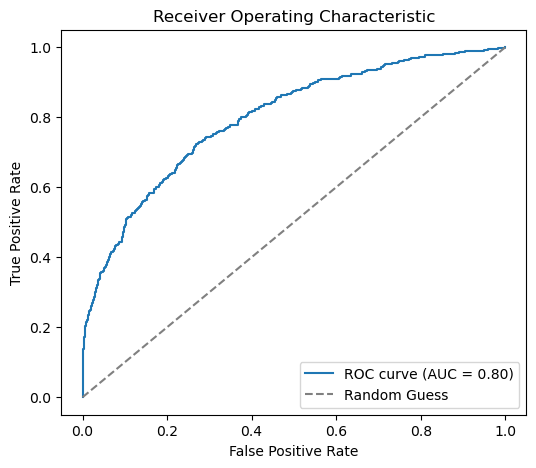

In [99]:
from sklearn.metrics import roc_curve, auc

y_prob = best_nb_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()